In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from utility import analysis_parameters as ap
import cartopy.crs as ccrs
import numpy as np

var="clt"

In [9]:
models = ["UM"]
das = [xr.open_dataset(ap.get_timmean_file(m, var, gt=True)).clt for m in models]
das

[<xarray.DataArray 'clt' (time: 1, latitude: 1280, longitude: 5120)>
 [6553600 values with dtype=float32]
 Coordinates:
   * time       (time) datetime64[ns] 2020-02-14
   * longitude  (longitude) float32 0.03516 0.1055 0.1758 ... 359.8 359.9 360.0
   * latitude   (latitude) float32 -29.98 -29.93 -29.88 ... 29.88 29.93 29.98
 Attributes:
     standard_name:  cloud_area_fraction
     long_name:      TOTAL CLOUD AMOUNT IN LW RADIATION
     units:          1
     cell_methods:   time: mean (interval: 1 hour)
     origin:         cloud_area_fraction]

TypeError: 'GeoAxesSubplot' object is not subscriptable

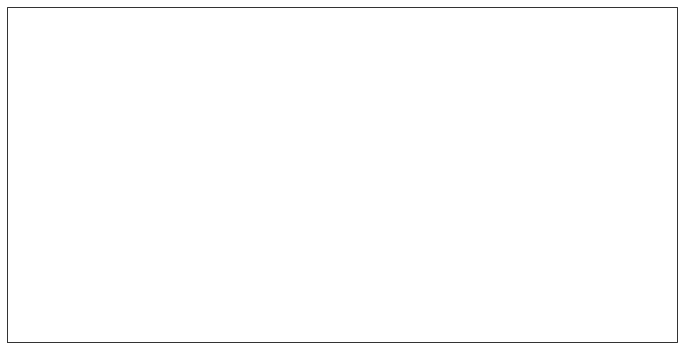

In [10]:
fig, ax = plt.subplots(len(models),1, figsize=(12,10), 
                       subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)} )
cmap = "YlGnBu_r"
vmin, vmax = 0, 0.8
# vmin, vmax = 180, 310

for i, da in enumerate(das):
    da.isel(time=0).plot(
        ax=ax[i],
        transform=ccrs.PlateCarree(),  
        cmap=cmap,
        vmin=vmin, vmax=vmax,
        cbar_kwargs={"orientation": "vertical", "shrink": 0.7},
        robust=True
    )
    ax[i].coastlines() 
    ax[i].set_xticks(np.arange(-180,181,30))
    ax[i].set_xticklabels([0,30,60,90,120,150,180,-150,-120,-90,-60,-30,0])
    ax[i].set_yticks(np.arange(-30,31,10))
    ax[i].set_title(models[i]+" "+var)
    ax[i].set_xlabel("Lon ($^\circ$E)")
    ax[i].set_ylabel("Lat ($^\circ$N)")
plt.savefig("../plots/GT/timmean_{}.png".format(var), dpi=150)
plt.show()